<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula6b_MLP_Fun%C3%A7%C3%B5es_de_Ativa%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

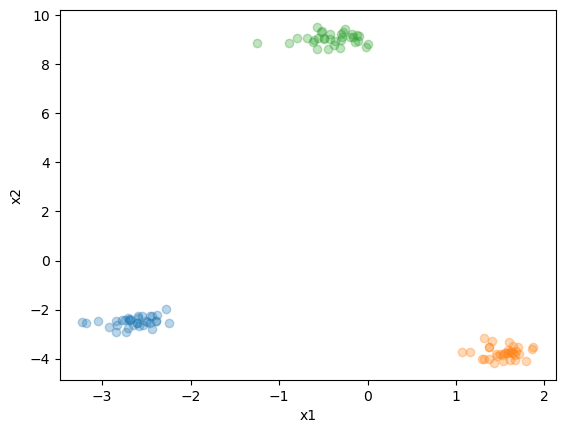

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

def criaDataset(n=100, centros=3):
  X, y = make_blobs(n_samples=n, centers=centros, cluster_std=0.2)
  return X, y

X, y = criaDataset()

def plotDataset(X, y):
  plt.xlabel("x1")
  plt.ylabel("x2")
  for k in set(y):
    plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotDataset(X, y)

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [3]:
from scipy.special import expit
from abc import ABC, abstractmethod

class ActivationFunction(ABC):
  @abstractmethod
  def forward(a):
    pass
  @abstractmethod
  def backward(a):
    pass

class TanH(ActivationFunction):
  def forward(self, a):
    return expit(a)*2-1
  def backward(self, a):
    return (1 - np.square(self.forward(a)))

class Sigmoid(ActivationFunction):
  def forward(self, a):
    return expit(a)
  def backward(self, a):
    return self.forward(a) * (1 - self.forward(a))

1.0

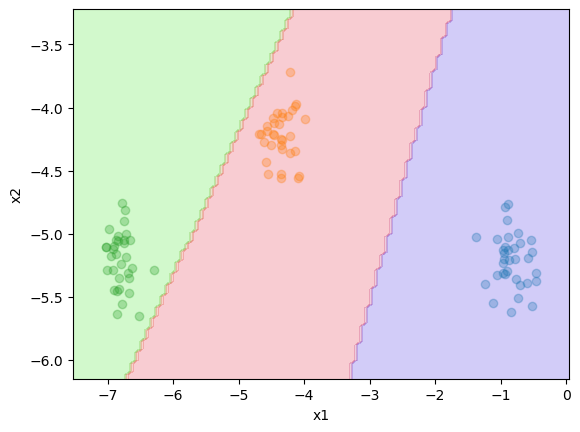

In [31]:
from sklearn.preprocessing import label_binarize

class Backpropagation(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=1000, learning_rate=0.001, n_hidden=[2],
               activations=[TanH()], output_activation=TanH()):
    if len(n_hidden) != len(activations):
        raise AttributeError("n_hidden and activations parameters should have the same size")
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.n_hidden = n_hidden
    self.activations = activations
    self.output_activation = output_activation
    # Doing this because cross_validate will recreate the instance
    # using the parameters with same name of attributes
    self.all_activations = activations + [output_activation]

  def forward(self, X):
    self.A = []
    self.Z = []
    AUX = X.copy()
    count = 0
    for W in self.Ws:
      self.A.append(include_bias(AUX))
      self.Z.append(self.A[-1] @ W)
      AUX = self.all_activations[count].forward(self.Z[-1])
      count += 1
    return AUX

  def backward(self, X, y, ypred):
    grads = []
    output_delta = y - ypred
    grads.insert(0, self.A[-1].T @ output_delta)
    for i in range(len(self.Ws)-1, 0, -1):
      tanh_grad = self.all_activations[i-1].backward(self.Z[i-1])
      input_delta = (output_delta @ self.Ws[i][1:,:].T) * tanh_grad
      grads.insert(0, self.A[i-1].T @ input_delta)
      output_delta = input_delta.copy()
    for i in range(len(self.Ws)-1, -1, -1):
      self.Ws[i] += grads[i] * self.learning_rate

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels)

  def fit(self, X, y):
    yhot = self.encode_labels(y)
    self.Ws = []
    previous_output = X.shape[1]
    for layer_size in self.n_hidden:
      self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, layer_size)))
      previous_output = self.Ws[-1].shape[1]
    self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, yhot.shape[1])))
    for _ in range(self.max_iter):
      ypred = self.forward(X)
      self.backward(X, yhot, ypred)

  def predict(self, X):
    a = self.forward(X)
    if len(self.labels) <= 2:
      idx = np.array(a > 0, dtype=int).reshape(-1,)
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

X, y = criaDataset(centros=3)
clf = Backpropagation(n_hidden=[5])
clf.fit(X, y)
plotDataset(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
accuracy_score(y, ypred)

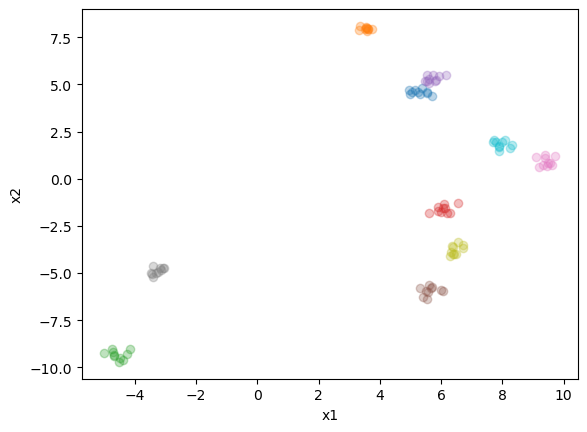

In [24]:
# Dataset a ser usado em todos as redes
X, y = criaDataset(centros=10)
plotDataset(X, y)

0.8

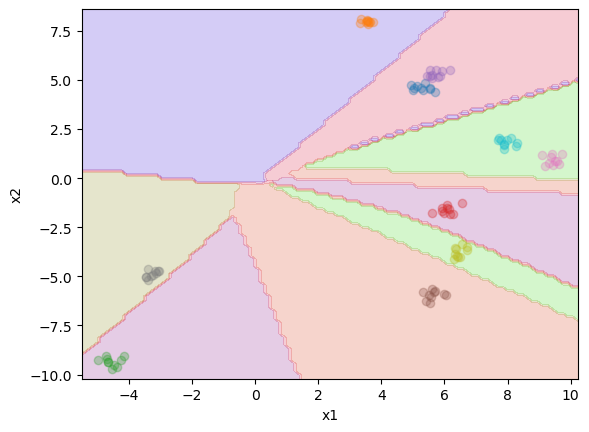

In [25]:
# Single layer
clf = Backpropagation(n_hidden=[5], activations=[Sigmoid()], output_activation=Sigmoid())
clf.fit(X, y)
plotDataset(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
accuracy_score(y, ypred)

0.5

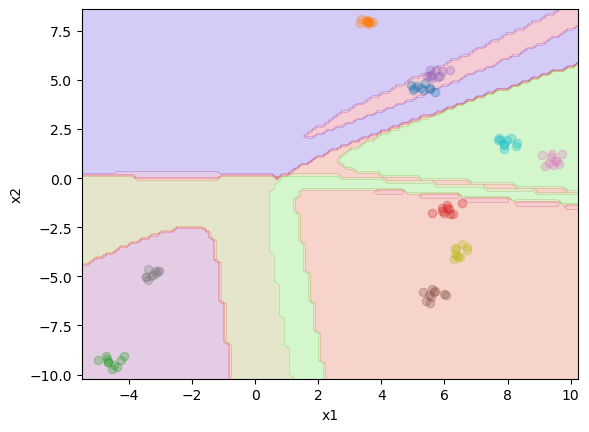

In [26]:
# Multiple layer, same activation
clf = Backpropagation(n_hidden=[5, 10], activations=[Sigmoid(), Sigmoid()], output_activation=Sigmoid())
clf.fit(X, y)
plotDataset(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
accuracy_score(y, ypred)

0.69

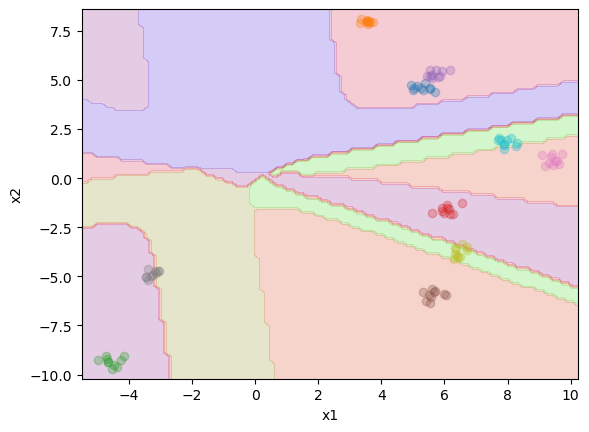

In [27]:
# Multiple layer, different activation
clf = Backpropagation(n_hidden=[5, 10], activations=[Sigmoid(), TanH()], output_activation=Sigmoid())
clf.fit(X, y)
plotDataset(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
accuracy_score(y, ypred)

In [34]:
from sklearn.model_selection import cross_validate

In [35]:
print("Teste sem nenhum parâmetro")
scores = cross_validate(Backpropagation(), X, y)
scores['test_score'], np.mean(scores['test_score'])

Teste sem nenhum parâmetro


(array([1.  , 0.65, 1.  , 0.7 , 0.65]), 0.7999999999999999)

In [36]:
print("Teste com uma camada oculta")
scores = cross_validate(Backpropagation(n_hidden=[5], activations=[Sigmoid()], output_activation=Sigmoid()), X, y)
scores['test_score'], np.mean(scores['test_score'])

Teste sem nenhum parâmetro


(array([1. , 1. , 0.8, 1. , 1. ]), 0.96)

In [39]:
print("Teste com duas camadas ocultas e mesma ativação")
scores = cross_validate(Backpropagation(n_hidden=[5, 10], activations=[Sigmoid(), Sigmoid()], output_activation=Sigmoid()), X, y)
scores['test_score'], np.mean(scores['test_score'])

Teste com duas camadas ocultas e mesma ativação


(array([1.  , 0.95, 1.  , 1.  , 1.  ]), 0.99)

In [40]:
print("Teste com duas camadas ocultas e diferentes ativações")
scores = cross_validate(Backpropagation(n_hidden=[5, 10], activations=[Sigmoid(), TanH()], output_activation=Sigmoid()), X, y)
scores['test_score'], np.mean(scores['test_score'])

Teste com duas camadas ocultas e diferentes ativações


(array([1., 1., 1., 1., 1.]), 1.0)

In [41]:
from sklearn.neural_network import MLPClassifier

print("Teste MLPClassifier do sklearn")
scores = cross_validate(MLPClassifier(), X, y)
scores['test_score'], np.mean(scores['test_score'])

Teste MLPClassifier do sklearn


C:\Users\duduu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\duduu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\duduu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\duduu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\duduu\anaconda3\lib\site-packages\sklearn\neural_network\_multi

(array([1., 1., 1., 1., 1.]), 1.0)